# Ensemble of CNNs for MNIST

Import Library

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
n_epochs = 2 # digunakan untuk menentukan banyaknya iterasi yang dibutuhkan pada training
batch_size_train = 64 # digunakan untuk menentukan banyaknya iterasi batch_size_train
batch_size_test = 1000 # digunakan untuk menentukan banyaknya nilai batch size data test
learning_rate = 0.03 # digunakan untuk menentukan nilai learning_rate
momentum = 0.7 # digunakan untuk menentukan nilai momentum
log_interval = 10 # digunakan untuk menilai batas waktu log_interval

random_seed = 1 # digunakan untuk menyimpan nilai status fungsi acak
torch.backends.cudnn.enabled = False # digunakan untuk menjalankan gpu, karena di google colab gpu sudah otomatis berjalan sehingga harus bernilai false
torch.manual_seed(random_seed) # digunakan untuk menyimpan status fungsi acak

In [3]:
train_loader = torch.utils.data.DataLoader( #digunakan untuk menyimpan data dengan DataLoader pada train
  torchvision.datasets.MNIST('/files/', train=True, download=True, # digunakan untuk memanggil data MNIST
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader( #untuk menyimpan DataLoader pada test
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
# digunakan untuk memperlihatkan data test 1000 pada channel 1 dengan skala ukuran gambar 28x28
example_data.shape 

torch.Size([1000, 1, 28, 28])

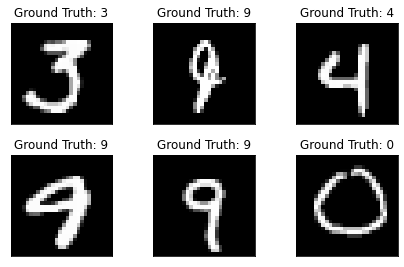

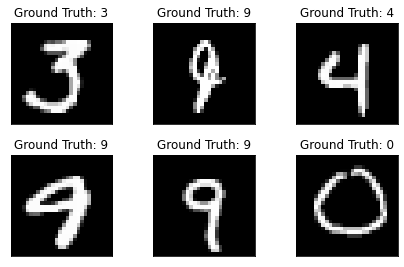

In [6]:
# digunakan untuk memperlihatkan nilai gambar asli
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [7]:
class Net(nn.Module): # digunakan untuk membuat arsitektur nn.Module
    def __init__(self): # digunakan untuk menurunkan class
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # digunakan untuk mematikan sebagian nn yang mempunyai bobot yang sama
        self.fc1 = nn.Linear(320, 50) # nn.linear berisi 320 hidden layer dan 50 hidden layer
        self.fc2 = nn.Linear(50, 10) # nn.linear yang berisi 50 hidden layer serta 10 hidden layer
    def forward(self, x): # digunakan untuk menambahkan aktivasi relu, pooling, dan dropout
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x) # mengembalikan fungsi aktivasi F.log_softmax

In [8]:
class Net(nn.Module): # digunakan untuk membuat arsitektur nn.Module
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # nn.linear yang berisi 1 hidden layer serta 10 hidden layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # nn.linear yang berisi 10 hidden layer serta 20 hidden layer
        self.conv2_drop = nn.Dropout2d() # digunakan untuk mematikan sebagian nn yang mempunyai bobot yang sama
        self.fc1 = nn.Linear(320, 50) # disambungkan ke 320 hiden layer dan 50 hiden layer
        self.fc2 = nn.Linear(50, 10) # disambungkan ke 50 hiden layer dan disambungkan ke output 10 layer terakhir
    def forward(self, x): #untuk menambahkan aktivasi relu, pooling, dan dropout
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x) # mengembalikan fungsi aktivasi F.log_softmax

In [9]:
network = Net() # memanggil arsitektur yang telah dibuat
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum) # algortima optimasi 

In [10]:
train_losses = [] # di dalam train losses terdapat list kosong yang digunakan untuk menyimpan proses training loss
train_counter = [] #di dalam train_counter terdapat list kosong yang digunakan untuk menyimpan proses training counter
test_losses = [] #di dalam test_losses terdapat list kosong untuk menyimpan proses training test loss
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)] # di dalam test_counter terdapat nilai variabel train_loader.dataset

In [11]:
# dilakukan proses training
def train(epoch): 
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [12]:
# dilakukan proses testing
def test(): 
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [13]:
# memanggil semua hasil training
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325928
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.256222
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.165100
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.745337
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.449717
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.306892
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.992492
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.092531
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.991566
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.743223
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.988574
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.689782
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.911227
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.647519
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.508461
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.671086
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.558270
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.684302
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.795890
Train Epoch: 1 [12160/6

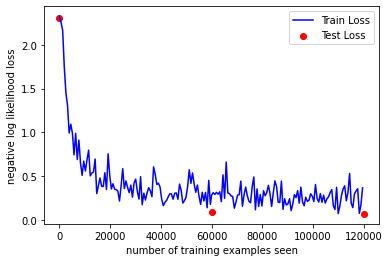

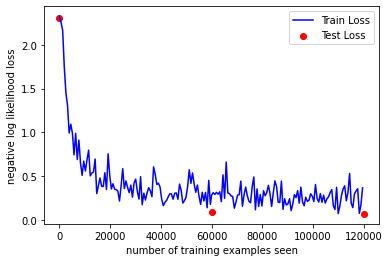

In [14]:
# digunakan untuk visualisasi plot
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig